### Influence of the SNR on the Maximum-Likelihood changepoint estimator 

In [2]:
# Imports
import numpy as np
# AIS processing
from ais_processing.ais import GenAIS
from ais_processing.modulator import Modulator
from ais_processing.channel import AWGN
from ais_processing.demodulator import Demodulator
from ais_processing.detector import Detector
from ais_processing.decoder import Decoder
# Plots
import matplotlib.pyplot as plt
# Progress bar
from tqdm import tqdm

In [1]:
# AIS signal parameters
# Bitrate in bits/s
C_BITRATE_BITPERSEC = 9600
# Signal duration in s
C_SIGNAL_DURATION = 26.66e-3
# Upsampling factor
C_UPSAMPLING = 10
# Time-Bandwidth product
C_TIME_BANDWIDTH_PROD = 0.4
# Sampling frequency in Hz
C_SAMPLING_FREQUENCY_HZ = C_BITRATE_BITPERSEC * C_UPSAMPLING
# Signal to Noise Ratio in dB
C_SNR_DB = 15

In [24]:
# Create a GenAIS object
ais_generator = GenAIS()
# Create a GMSK modulator object
gmsk_modulator = Modulator(
    sampling_frequency_hz = C_SAMPLING_FREQUENCY_HZ, 
    upsampling = C_UPSAMPLING, 
    time_bandwidth_prod = C_TIME_BANDWIDTH_PROD
    )
# AWGN channel
awgn_channel = AWGN(snr_db = C_SNR_DB, add_phase = True)
# Detector
detector = Detector()

In [3]:
def get_random_start(v_ais_bits : np.ndarray, n : int) -> tuple[np.ndarray, int]:
    """Put randomly the beginning of the signal 
    v_ais_bits in a null signal of size n.

    Parameters
    ----------
    v_ais_bits: array-like
        The input signal
    n: int
        The size of the output signal

    Returns
    -------
    s: array-like
        The output signal
    t0: int
        The starting point of signal x
    """
    if n >= v_ais_bits.size:
        raise TypeError("N must be smaller than the size of x.")
    else:
        v_signal = np.zeros(n, dtype=complex)
        t0 = np.random.randint(low=int(n/3), high=int((2*n)/3))
        v_signal[t0:] = v_ais_bits[:n-t0]
        
        return v_signal, t0

In [4]:
def get_random_end(v_ais_bits : np.ndarray, n : int) -> tuple[np.ndarray, int]:
    """Put randomly the end of the signal v_ais_bits
    in a null signal of size N.

    Parameters
    ----------
    v_ais_bits: array-like
        The input signal
    n: int
        The size of the output signal

    Returns
    -------
    v_signal: array-like
        The output signal
    t0: int
        The ending point of signal x
    """
    if n >= v_ais_bits.size:
        raise TypeError("N must be smaller than the size of x.")
    else:
        v_signal = np.zeros(n, dtype=complex)
        t0 = np.random.randint(low=int(n/3), high=int((2*n)/3))
        v_signal[:t0] = v_ais_bits[-t0:]
        
        return v_signal, t0

#### Influence of the SNR on the estimation of a starting point

In [17]:
# Example of starting point

# Generate AIS bits
v_ais_bits = ais_generator.gen_rand_ais_type_1()
# GMSK modulation
v_signal_tx = gmsk_modulator.mod_signal_gmsk(v_signal = v_ais_bits)
# Place the signal at a random position
v_signal_tx, t0 = get_random_start(v_signal_tx, 1000)
v_signal_rx = awgn_channel.propagate(v_signal_tx=v_signal_tx)

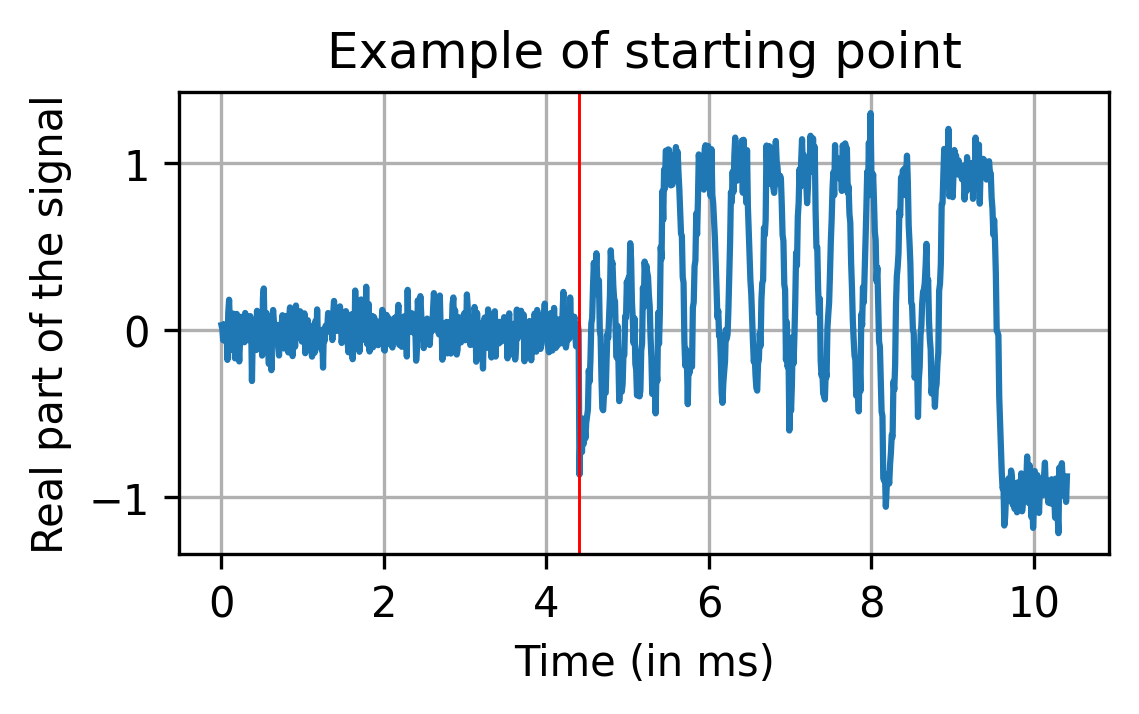

In [23]:
plt.figure(figsize=(4, 2), dpi=300)
plt.plot(np.arange(0, v_signal_rx.size, 1) / C_SAMPLING_FREQUENCY_HZ * 1e3, np.real(v_signal_rx))
plt.axvline(x = t0 / C_SAMPLING_FREQUENCY_HZ * 1e3, color='r', linewidth=0.7)
plt.title('Example of starting point')
plt.xlabel('Time (in ms)')
plt.ylabel('Real part of the signal')
plt.grid(True)
plt.show()

**Experiments:** Let's study the influence of the SNR on the estimation $\hat{t}_0$ of the changepoint $t_0$, obtained by the Maximum-Likelihood method. To evaluate the performance of the estimator for a given SNR, we compute the mean error $\mathbb{E}(|\hat{t}_0 - t_0|)$ which represents the average number of bits between the real changepoint and the estimated one.

In [46]:
# Parameters
C_SIGNAL_LENGTH = 1000 # Signal length
snr_vec = np.arange(start=5, stop=21) # Tested SNR
error_means = list() # List of the error means
n = 100 # Number of realizations at each SNR to estimate the error mean

In [47]:
for snr in snr_vec:
    e = 0 # Mean error for the current SNR
    for _ in range(n):
        # Generate AIS bits
        v_ais_bits = ais_generator.gen_rand_ais_type_1()
        # GMSK modulation
        v_signal_tx = gmsk_modulator.mod_signal_gmsk(v_signal = v_ais_bits)
        # Place the signal at a random position
        v_signal_tx, t0 = get_random_start(v_signal_tx, C_SIGNAL_LENGTH)
        v_signal_rx = AWGN(snr_db = snr, add_phase = True).propagate(v_signal_tx=v_signal_tx)
        # Estimate the changepoint
        # Note: The implemented estimator works with real signals. If the
        # signal is complex, we consider the real part and the imaginary part
        # of the signal, apply the estimator on them and take the mean
        # changepoint.
        t0_hat = np.mean([detector.mle_detector(np.real(v_signal_rx)), detector.mle_detector(np.imag(v_signal_rx))])
        e += np.abs(t0_hat - t0)

    error_means.append(e / n)

5 0
6 1
7 2
8 3
9 4
10 5
11 6
12 7
13 8
14 9
15 10
16 11
17 12
18 13
19 14
20 15


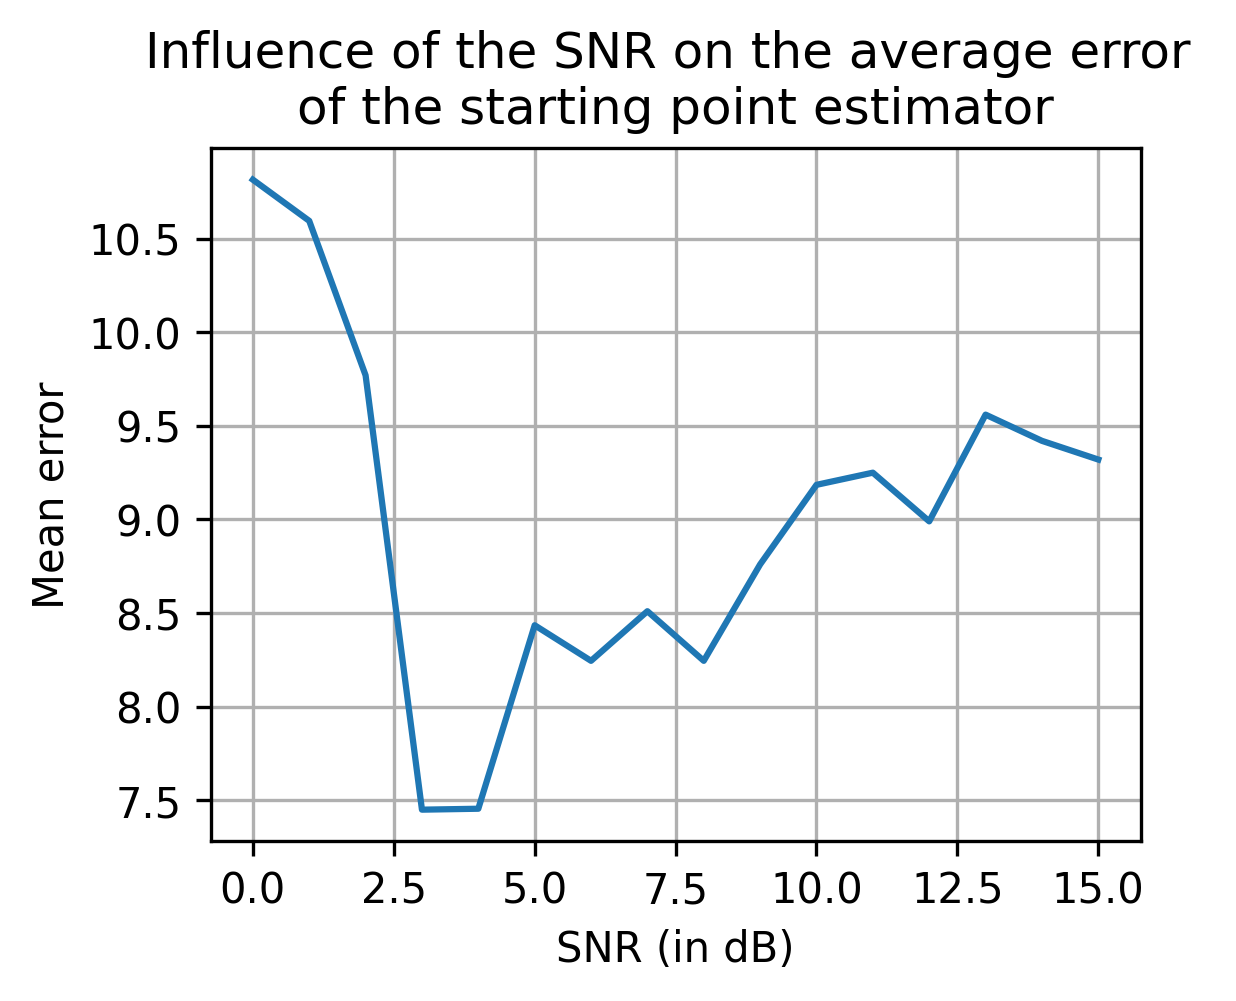

In [48]:
# Plot the results
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(error_means)
plt.title("Influence of the SNR on the average error \nof the starting point estimator")
plt.xlabel("SNR (in dB)")
plt.ylabel("Mean error")
plt.grid(True)
plt.show()

**Conclusion:**
- The average error is high with a low SNR, and low with a high SNR, which is consistent. As the estimator is based on the change of variance, a low SNR reduces the gap between the variance of the two parts of the signal (i.e. before and after the changepoint) so the estimator becomes less performant.
- If the SNR is greater than 15dB, the average error is almost equal to one i.e. the estimated changepoint is in average one bit away from the actual changepoint, which seems pretty good.
- And if the SNR is lower than 8dB the average error is almost equal to 3, so not significantly high compared to the length $N=1000$ of the signal. 

#### Influence of the SNR on the estimation of an ending point

In [31]:
# Example of ending point

# Generate AIS bits
v_ais_bits = ais_generator.gen_rand_ais_type_1()
# GMSK modulation
v_signal_tx = gmsk_modulator.mod_signal_gmsk(v_signal = v_ais_bits)
# Place the signal at a random position
v_signal_tx, t0 = get_random_end(v_signal_tx, 1000)
v_signal_rx = awgn_channel.propagate(v_signal_tx=v_signal_tx)

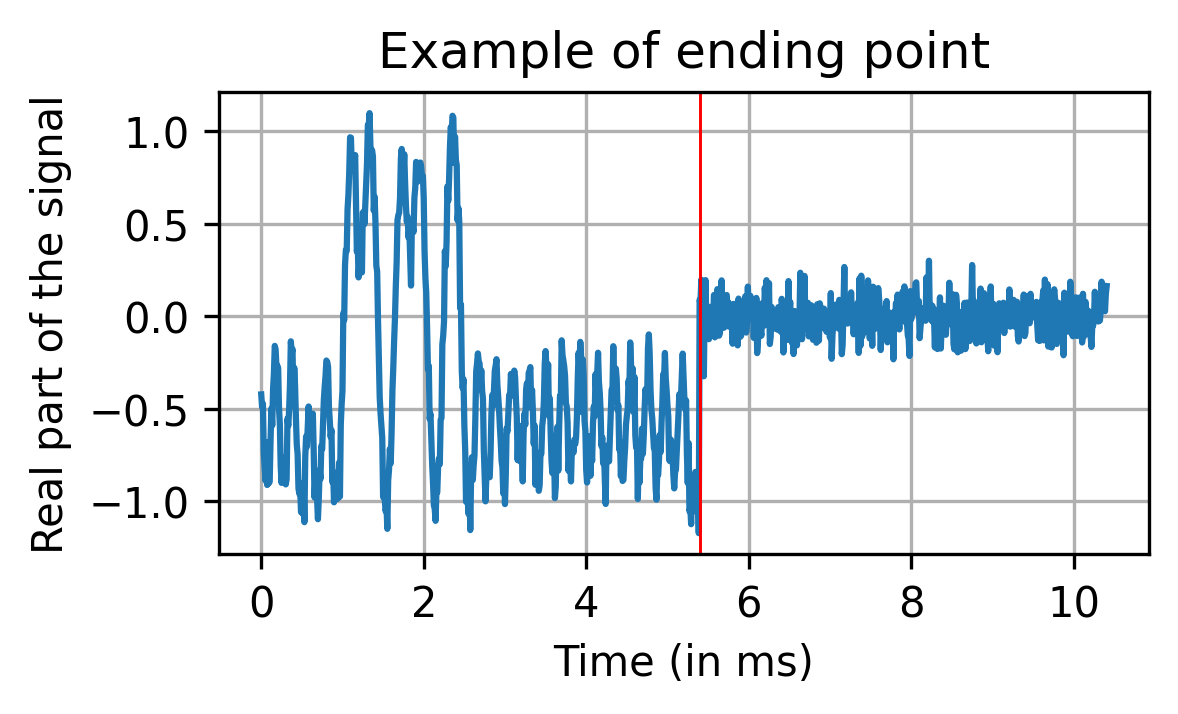

In [32]:
plt.figure(figsize=(4, 2), dpi=300)
plt.plot(np.arange(0, v_signal_rx.size, 1) / C_SAMPLING_FREQUENCY_HZ * 1e3, np.real(v_signal_rx))
plt.axvline(x = t0 / C_SAMPLING_FREQUENCY_HZ * 1e3, color='r', linewidth=0.7)
plt.title('Example of ending point')
plt.xlabel('Time (in ms)')
plt.ylabel('Real part of the signal')
plt.grid(True)
plt.show()

In [31]:
# Parameters

N = 1000 # Signal length
snr_vec = np.arange(start=5, stop=21) # Tested SNR
error_means = list() # List of the error means
n = 200 # Number of realizations at each SNR to estimate the error mean

In [32]:
for snr in snr_vec:
    e = 0 # Mean error for the current SNR
    for _ in range(n):
        # Generate a random AIS signal
        bits = gen_rand_ais_type_1() 

        # Apply GMSK modulation
        x = mod_signal_gmsk(
            bits,
            fs_hz=Fs,
            up_sampling_factor=upsampling_factor,
            time_bandwidth_product=time_bandwidth_product
        )

        # Translate randomly the signal
        s, t0 = get_random_end(x, N)

        # Add noise
        y = awgn_channel(s, snr_db=snr)

        # Estimate the changepoint
        # Note: The implemented estimator works with real signals. If the
        # signal is complex, we consider the real part and the imaginary part
        # of the signal, apply the estimator on them and take the mean
        # changepoint.
        t0_hat = np.mean([mle_detector(np.real(y)), mle_detector(np.imag(y))])

        e += np.abs(t0_hat - t0)
    error_means.append(e / n)

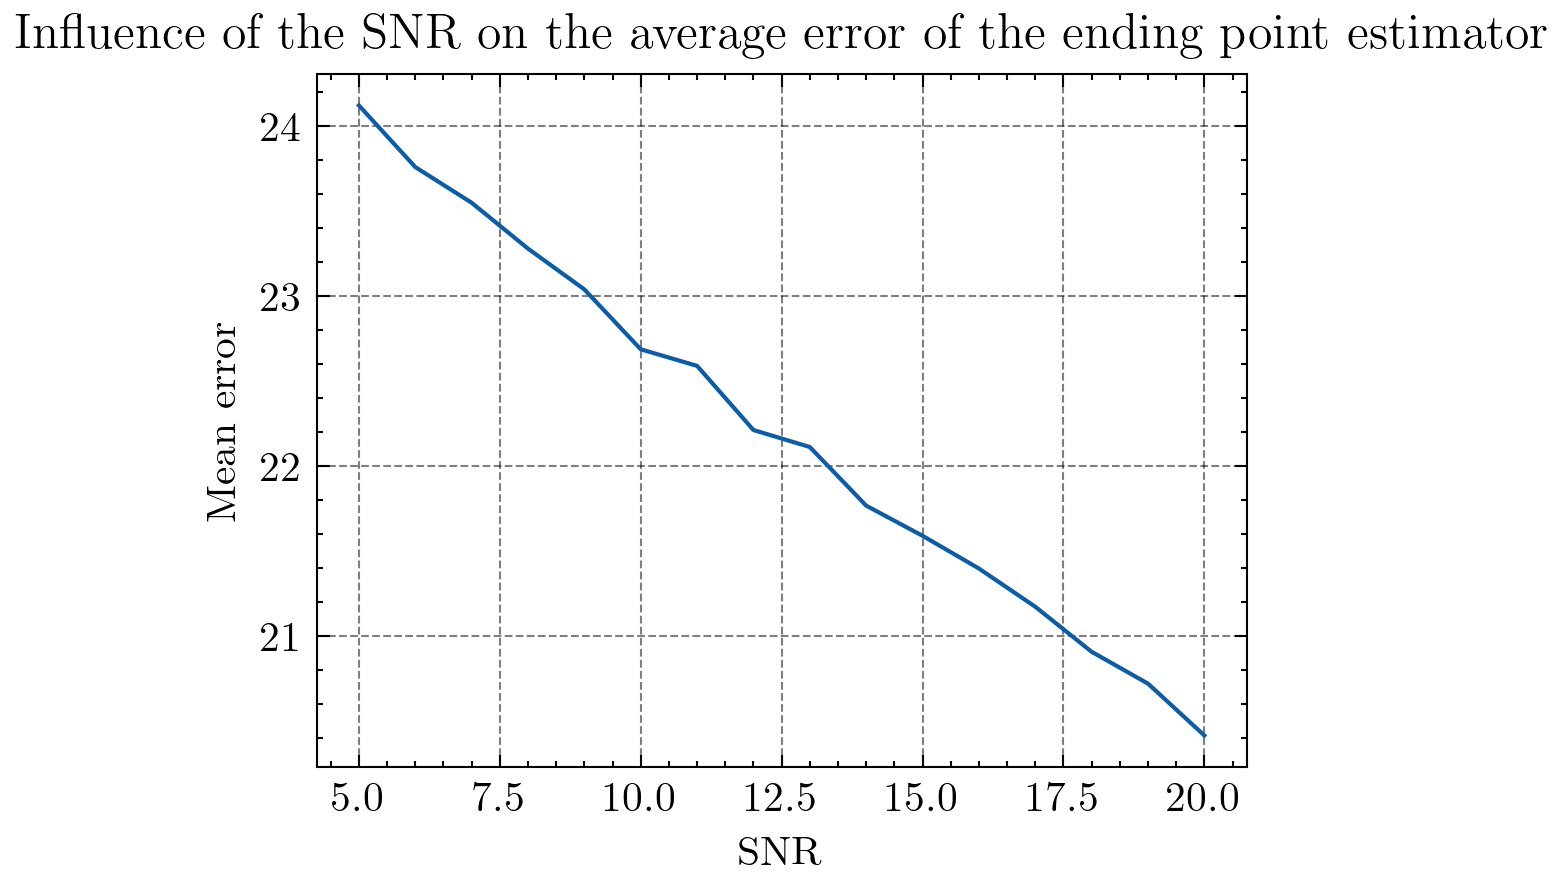

In [33]:
# Plot the results
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(snr_vec, error_means)
plt.title("Influence of the SNR on the average error of the ending point estimator")
plt.xlabel("SNR")
plt.ylabel("Mean error")
plt.grid(True)
plt.show()

**Conclusions:**
- As in the first experiment, the average changepoint estimation error decreases as the SNR increases.
- But we observe that the estimator is less performant with ending points than with starting points. For instance, for an SNR of 10dB, the estimator has an average error of 2 symbols for starting points and an average error of 23 symbols for ending points.